In [3]:
# mlflow test

import mlflow
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
import nltk
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
import re
from wordcloud import WordCloud 
import mlflow.sklearn
from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer

In [4]:
# mlflow.set_tracking_uri("http://ec2-13-217-3-143.compute-1.amazonaws.com:5000")

# with mlflow.start_run():
#     mlflow.log_param("param1", 15)
#     mlflow.log_metric("metric1", 0.89)


In [5]:
data = pd.read_csv("https://raw.githubusercontent.com/Himanshu-1703/reddit-sentiment-analysis/refs/heads/main/data/reddit.csv")
data.head()

,clean_comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


In [6]:
data.dropna(inplace = True)

In [7]:
data.drop_duplicates(inplace = True)

In [8]:
# removing the rows with white spaces
data = data[~(data["clean_comment"].str.strip() == "")]

In [9]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\henny\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\henny\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [10]:
def pre_process_comment(comment):
    comment = re.sub(r'http\S+|www\S+|https\S+', '', comment, flags=re.MULTILINE)
    comment = re.sub(r'\@\w+|\#','', comment)
    comment = re.sub(r'[^\w\s]', '', comment)
    comment = re.sub(r'\d+', '', comment)
    comment = comment.lower()
    stop_words = set(stopwords.words('english'))
    word_tokens = nltk.word_tokenize(comment)
    filtered_comment = [w for w in word_tokens if not w in stop_words]
    lemmatizer = WordNetLemmatizer()
    lemmatized_comment = [lemmatizer.lemmatize(w) for w in filtered_comment]
    return ' '.join(lemmatized_comment) 

In [11]:
# function to preprocess the comments
def pre_process_comment(comment):
    # convert to lowercase
    comment = comment.lower()

    # remove trailing and leading whitespaces
    comment = comment.strip()

    # remove newline characters
    comment = re.sub(r'\n', ' ', comment)

    # remove non-alphanumeric characters, except punctuation
    comment = re.sub(r'[^a-zA-Z0-9\s.,!?\'\"-]', '', comment)

    # remove stopwords but retain important words
    stop_words = set(stopwords.words('english')) - {'not', 'no', 'nor', 'but', 'however', 'yet'}
    comment = ' '.join([word for word in comment.split() if word not in stop_words])

    # lemmatize the words
    lemmatizer = WordNetLemmatizer()
    comment = ' '.join([lemmatizer.lemmatize(word) for word in comment.split()])

    return comment

In [12]:
data['clean_comment'] = data['clean_comment'].apply(pre_process_comment)

In [13]:
data.head()

,clean_comment,category
0,family mormon never tried explain still stare ...,1
1,buddhism much lot compatible christianity espe...,1
2,seriously say thing first get complex explain ...,-1
3,learned want teach different focus goal not wr...,0
4,benefit may want read living buddha living chr...,1


In [14]:
# step 1: vectorize the comments using Bag of Words(CountVectorizer)
# Bag of word model with a maximum of 10,000 features
vectorizer = CountVectorizer(max_features = 10000)

In [15]:
x = vectorizer.fit_transform(data['clean_comment']).toarray()
y = data['category']

In [16]:
# step2: set up the MLflow tracking server
mlflow.set_tracking_uri("http://ec2-54-84-240-136.compute-1.amazonaws.com:5000")

In [17]:
# set the experiment name
mlflow.set_experiment("YouTube-sentiment-analysis")

<Experiment: artifact_location='s3://youtube-sentiment-analysis/mlflow/653002945017796553', creation_time=1754602388772, experiment_id='653002945017796553', last_update_time=1754602388772, lifecycle_stage='active', name='YouTube-sentiment-analysis', tags={}>

🏃 View run RandomForestBaseModel at: http://ec2-54-84-240-136.compute-1.amazonaws.com:5000/#/experiments/653002945017796553/runs/4090d4a8535d49a29ac37e8d8959d1bf
🧪 View experiment at: http://ec2-54-84-240-136.compute-1.amazonaws.com:5000/#/experiments/653002945017796553


FileNotFoundError: [WinError 3] The system cannot find the path specified: '/content/confusion_matrix.png'

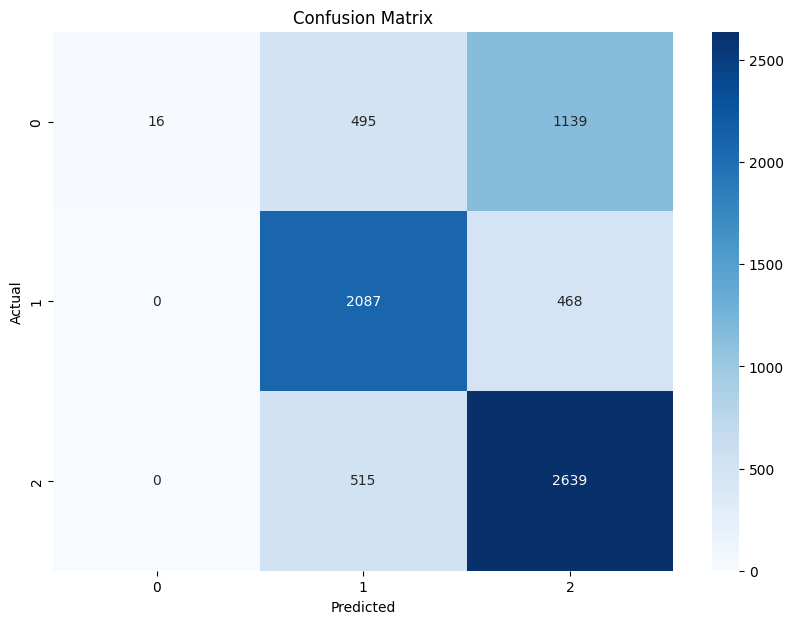

In [ ]:
# split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# Define and train Random Forest base model 
with mlflow.start_run() as run:
    # log a description of the run
    mlflow.set_tag("mlflow.runName", "RandomForestBaseModel")
    mlflow.set_tag("experiment type", "base model")
    mlflow.set_tag("model type", "Random Forest")

    # add a description of the run
    mlflow.set_tag("description", "This is a random forest base model for YouTube comment sentiment analysis using bag of words vectorization.")

    # log parameter for vectorizer
    mlflow.log_param("vectorizer_type", "CountVectorizer")
    mlflow.log_param("vectorizer_max_features", vectorizer.max_features)
    
    # log Random Forest parameters
    n_estimators = 200
    max_depth = 15

    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_param("max_depth", max_depth)    

    # train the model
    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    model.fit(x_train, y_train)

    # make predictions on the test set
    y_pred = model.predict(x_test)

    # log metrics for each class and accuracy
    accuracy = accuracy_score(y_test, y_pred)
    mlflow.log_metric("accuracy", accuracy)

    class_report = classification_report(y_test, y_pred, output_dict=True)
    for label, metrics in class_report.items():
        if isinstance(metrics, dict):
            for metric, value in metrics.items():
                mlflow.log_metric(f"{label}_{metric}", value)
            
    
    # confusion_matrix plot
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7)) 
    sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')

    # save the confusion matrix plot
    plt.savefig("confusion_matrix.png") 
    mlflow.log_artifact("confusion_matrix.png")

    # log the model
    mlflow.sklearn.log_model(model, "Random_Forest_Model")

    # Optionally, log the dataset (if it small)
    data.to_csv("data.csv", index=False)
    mlflow.log_artifact("data.csv")


# Display final accuracy
print(f"Accuracy: {accuracy}")